# 💻 **Hands-on: Banco de dados vetorial**

**Banco de dados vetorial** é um tipo de banco de dados especializado em armazenar e buscar vetores, que são listas de números (chamadas embeddings), que representam semanticamente textos, imagens, áudios, etc.

### **O que são embeddings?**

Embeddings são representações numéricas de textos utilizadas em Natural Language Processing (NLP). Esses vetores posicionam os textos em um espaço multidimensional de forma que conteúdos semanticamente semelhantes fiquem próximos entre si.

Essa capacidade de capturar o **significado e contexto** das palavras torna os embeddings ideais para tarefas como buscas semânticas, recomendações inteligentes e compreensão de linguagem natural — mesmo quando o vocabulário usado é diferente, mas o sentido é parecido.

<div style="text-align: center;">
  <img src="figures/embedding.png" alt="drawing" width="600"/>
</div>

Com documentos de texto em formato de vetores de embeddings, é possível comparar os mesmos conforme o exemplo a seguir:

<div style="text-align: center;">
  <img src="figures/vector_similarity.webp" alt="drawing" width="800"/>
  <p style="font-size: 14px; color: gray; margin-top: 5px;">
    Fonte: <a href="https://medium.com/@SaumyaBhatt106/understanding-vector-embeddings-ad140dcb916f" target="_blank" rel="noopener noreferrer">Saumya Bhatt no Medium</a>
  </p>
</div>

### **Gerando embeddings com a API da OpenAI**

A OpenAI disponibiliza seus modelos de embeddings por meio do endpoint **Embeddings**, cuja estrutura de requisição é bastante semelhante à de outros serviços da API.

Para fazer essas requisições, usamos a biblioteca `openai` e uma **chave de API válida**. O primeiro passo é configurar o cliente passando a chave.

Em seguida, fazemos a chamada ao método `create()` através de `client.embeddings()`, onde:

- O modelo desejado é definido com o argumento `model`;
- O texto a ser convertido em embedding é passado pelo argumento `input`, que pode ser uma **string única** ou uma **lista de strings**.

Após obter a resposta, utilizamos o método `.model_dump()` para convertê-la em um **dicionário Python**, o que facilita a manipulação dos dados — e então exibimos o resultado com `pprint()` (para melhorar a leitura). A resposta da API costuma ser bastante extensa, já que o modelo de embedding retorna **1.536 números** (valores `float`) para representar a string fornecida.

In [1]:
from openai import  OpenAI
from dotenv import load_dotenv
import os
import pprint

load_dotenv()  

# OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# request para obter embeddings
response = client.embeddings.create(
  model="text-embedding-3-small",
  input="Esse é apenas um texto"
)

response_dict = response.model_dump()
pprint.pprint(response_dict)

{'data': [{'embedding': [0.03072541579604149,
                         0.04468948021531105,
                         -0.050037894397974014,
                         0.013538875617086887,
                         -0.008173676207661629,
                         -0.03506680577993393,
                         -0.03869209438562393,
                         0.021046798676252365,
                         0.022814683616161346,
                         -0.023631492629647255,
                         0.005700873676687479,
                         -0.012688499875366688,
                         -0.0017650889931246638,
                         0.012789202854037285,
                         0.007524705957621336,
                         0.0208565816283226,
                         -0.03325416520237923,
                         -0.004623917862772942,
                         0.008302351459860802,
                         -0.016123570501804352,
                         -0.0004143483529333025,
       

### **Por que precisamos de bancos de dados vetoriais?**

Quando geramos embeddings, eles são vetores com valores do tipo *float* com centenas ou milhares de dimensões, o que pode resultar em cerca de 13 KB por embedding. Em cenários com centenas de milhares ou milhões de embeddings, armazená-los todos em memória torna‑se inviável.

Além disso, se cada consulta recalcula embeddings ao invés de reutilizá-los, isso gera custo computacional demasiado!

### **Limites da abordagem "in memory"**

Em um cenário onde é necessário medir a similaridade entre uma query e múltiplos documentos em embedding, geralmente usamos a distância de cosseno e comparamos esse valor em relação a todos os embeddings armazenados. Esse processo:
- Requer ler cada embedding em memória ou disco;
- Executar um cálculo de similaridade ($O(N)$ com $N$ embeddings);
- Classificar os resultados;

<div style="text-align: center;">
  <img src="figures/abordagem_in_memory.png" alt="drawing" width="1000"/>
</div>

Isso é lentíssimo e tem escalabilidade linear — ou seja, à medida que crescem os dados, cresce também o tempo de busca, de forma diretamente proporcional.

### **Solução: bancos de dados vetorial**

No diagrama a seguir, é apresentada uma aplicação típica que usa banco de dados vetorial, onde os documentos que precisam ser consultados/buscados são vetorizados com modelo de embedding e armazenado no banco de dados vetorial.

<div style="text-align: center;">
  <img src="figures/abordagem_vector_db.png" alt="drawing" width="1000"/>
</div>

Uma query é enviada da interface da aplicação e é usada para consultar os vetores de embeddings no banco de dados. Essa query pode ser uma consulta para busca semântica, ou dados para gerar recomendações. E por fim, esses resultados são retornados ao usuário por meio da interface do aplicação.

Como os documentos de embeddings são armazenados no banco de dados vetorial, eles não precisam ser criados a cada consulta ou armazenados em memória! Além disso, o cálculo de similaridade é realizado com muito mais eficiência.

### **Componentes que podem ser armazenados**

Bancos de dados vetoriais vão além do simples armazenamento de vetores de embeddings — é comum também manter os documentos originais associados a esses vetores. Nos casos em que a tecnologia utilizada não oferece suporte para guardar os documentos diretamente, é necessário armazená-los em um banco de dados separado, utilizando identificadores únicos para criar a ligação entre os dados.

Além dos vetores, os bancos de dados vetoriais também armazenam metadados. Esses metadados incluem identificadores, referências externas e informações adicionais que podem facilitar o processo de filtragem durante as buscas. No entanto, é importante manter esses metadados enxutos. Embora possa parecer prático incluir o conteúdo completo dos documentos como metadado, essa prática pode comprometer seriamente o desempenho do sistema, já que metadados volumosos tornam as buscas menos eficientes.

Em resumo, um banco de dados vetorial pode conter:

- Embeddings (vetores);
- Documentos originais (quando suportado);
- Metadados, como:
  - Identificadores e links de referência;
  - Informações auxiliares que otimizam a recuperação de dados.

Ainda sobre metadados em banco de dados vetoriais, supondo que uma plataform de streaming de filmes criou um motor de recomendação usando vetores de embeddings, a mesma estruturou os dados da seguinte forma para persistir os vetores de embedding de cada documento no banco de dados. Esse exemplo expressa qual tipo de dado pode ser usado como metadado, e qual não deve ser usado.  

<div align="center">
  <table>
    <thead>
      <tr>
        <th>Metadados</th>
        <th>Não é metadados</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Ano de lançamento</td>
        <td>Vetores de embedding</td>
      </tr>
      <tr>
        <td>Diretor</td>
        <td>Documentos originais</td>
      </tr>
      <tr>
        <td>Gênero do filme</td>
        <td>–</td>
      </tr>
      <tr>
        <td>ID de referência p/ outra tabela</td>
        <td>–</td>
      </tr>
    </tbody>
  </table>
</div>

### **Opções de bancos de dados vetoriais**

Quando se trata de banco de dados vetorial, o mercado oferece uma ampla variedade de alternativas, capazes de atender diferentes necessidades e cenários. Diversas soluções se destacam em popularidade e desempenho. Na hora de escolher a mais adequada, é fundamental levar em conta alguns critérios importantes, como requisitos técnicos, escalabilidade e integração com outras ferramentas.

<div style="text-align: center;">
  <img src="figures/vector_db_landscape.png" alt="drawing" width="800"/>
  <p style="font-size: 14px; color: gray; margin-top: 5px;">
    Fonte: <a href="https://x.com/YingjunWu/status/1667232357953466369/photo/1" target="_blank" rel="noopener noreferrer">Yingjun Wu no X</a>
  </p>
</div>


> ***E qual é a melhor solução de banco de dados vetorial?*** Depende do nível de gestão desejado.

Algumas opções são totalmente gerenciadas, o que significa que você pode focar no desenvolvimento da sua aplicação enquanto a infraestrutura é gerenciada automaticamente. Apesar de terem um custo mais elevado, essas soluções costumam compensar pelo ganho de praticidade.

Outra alternativa é fazer a gestão por conta própria, configurando o servidor e o banco manualmente, seja na nuvem ou em ambiente local. Essa abordagem costuma ser mais econômica, mas exige conhecimento técnico e dedicação para manutenção. Soluções open-source oferecem grande liberdade de customização e são ideais para quem precisa de flexibilidade ou tem um orçamento mais limitado.

Já as soluções comerciais tendem a oferecer vantagens como suporte técnico especializado, recursos avançados, maior estabilidade e conformidade com regulamentações. Também é importante avaliar se o tipo de dado que será trabalhado — como texto, imagem ou dados multimodais — demanda uma arquitetura específica.

No presente hands-on usaremos o Chroma, uma solução open-source que se destaca pela facilidade de instalação.

### **ChromaDB**

O ChromaDB (https://www.trychroma.com/) oferece duas formas de uso:

- **Modo local**: toda a execução ocorre dentro do ambiente Python, sem necessidade de processos externos. Ideal para desenvolvimento e prototipagem, pois é simples e rápido de configurar.
- **Modo cliente/servidor**: exige rodar um servidor Chroma em um processo separado e utilizar um cliente HTTP para se conectar a ele. Essa abordagem é mais indicada para ambientes de produção, pois permite escalabilidade e persistência de dados.

Neste hands-on vamos focar no **modo local**, que é o método mais prático para testes antes de migrar para um cenário mais robusto.

Para se conectar e realizar consultas no banco de dados, o primeiro passo é criar um cliente. Isso é feito importando o módulo `chromadb` e instanciando um cliente persistente por meio da classe `PersistentClient`. Esse tipo de cliente garante que os dados sejam salvos em disco, no path definido, permitindo que as informações permaneçam disponíveis mesmo após a finalização do processo.




In [2]:
import chromadb

client = chromadb.PersistentClient(path="chromadb_example")

Antes de inserir os vetores de embeddings no banco vetorial, é necessário criar uma **collection** — estrutura semelhante a uma tabela em bancos relacionais, que permite organizar os dados de forma separada e flexível. Podemos ter diversas coleções, cada uma com um propósito específico. Para criá-las, utilizamos o método `.create_collection()`.

Durante a criação, é preciso informar um nome (que servirá como identificador da collection) e também a função responsável pela geração dos embeddings. No exemplo, usamos a função de embeddings da OpenAI, fornecendo a chave da API. Vale lembrar que, no Chroma e em vários outros bancos vetoriais, uma função padrão de embedding será aplicada automaticamente caso nenhuma seja especificada.


In [3]:
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

collection = client.create_collection(
    name="my_collection",
    embedding_function=OpenAIEmbeddingFunction(
        model_name="text-embedding-3-small",
        api_key=os.getenv("OPENAI_API_KEY")
    )
)

Agora com o método `list_collections()` vamos checar todas as coleções existentes no banco de dados. Isso é útil para confirmar se a collection desejada foi criada corretamente. Em versões mais recentes (>= 0.6.0), esse método retorna uma lista de nomes (strings) das coleções.

In [4]:
client.list_collections()

[Collection(name=my_collection)]

Agora que a collection foi criada, podemos começar a inserir os embeddings. Para isso, utilizamos o método `add` da collection. No exemplo, estamos adicionando apenas um documento, mas é comum inserir vários de uma só vez, bastando fornecer listas de IDs e textos correspondentes.

É importante lembrar que o Chroma não gera IDs automaticamente — eles precisam ser definidos manualmente. Como a função de embedding já foi associada à collection no momento da criação, os textos fornecidos serão convertidos em vetores de forma automática.


In [5]:
# inclusão de um documento
collection.add(
    ids=["my-doc"],
    documents=["Este é um texto original que será vetorizado"]
)

In [6]:
# inclusão de múltiplos documentos
collection.add(
    ids=["my-doc-1", "my-doc-2"],
    documents=[
        "Este é um texto original que será vetorizado 1",
        "Este é um texto original que será vetorizado 2"
    ]
)

Após adicionar os documentos, é possível verificar o conteúdo da collection utilizando alguns métodos. Por exemplo, o método `count()` retorna a quantidade total de documentos armazenados na collection, permitindo acompanhar facilmente o volume de dados inserido.


In [7]:
collection.count()

3

Já o método `peek()` exibe uma prévia dos dados armazenados, retornando os dez primeiros itens da collection. Isso permite verificar rapidamente se os textos foram adicionados corretamente. Como a função de embedding foi definida anteriormente, os vetores foram gerados automaticamente no momento da inserção.


In [8]:
collection.peek()

{'ids': ['my-doc', 'my-doc-1', 'my-doc-2'],
 'embeddings': array([[ 0.02069862,  0.09862713, -0.0203476 , ...,  0.02270796,
          0.00401868, -0.01523951],
        [ 0.01844689,  0.08869215, -0.00212507, ...,  0.01601999,
          0.00107326, -0.01301701],
        [ 0.01496331,  0.08801655, -0.00070587, ...,  0.0198683 ,
         -0.00206754, -0.0074444 ]], shape=(3, 1536)),
 'documents': ['Este é um texto original que será vetorizado',
  'Este é um texto original que será vetorizado 1',
  'Este é um texto original que será vetorizado 2'],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': [None, None, None]}

Também é possível recuperar itens específicos da collection utilizando o método `get()`, informando o ID correspondente. Essa funcionalidade é útil quando queremos acessar diretamente um documento ou vetor já armazenado.

In [9]:
collection.get(ids=["my-doc-2"])

{'ids': ['my-doc-2'],
 'embeddings': None,
 'documents': ['Este é um texto original que será vetorizado 2'],
 'uris': None,
 'included': ['metadatas', 'documents'],
 'data': None,
 'metadatas': [None]}

### **Estimando o custo de geração de embeddings**

A OpenAI divulga os valores cobrados por mil tokens em sua página de preços (https://platform.openai.com/docs/pricing). Para calcular o custo total de embeddings, basta multiplicar esse valor pelo número de tokens nos textos que queremos processar e dividir o resultado por 1M. Para contar os tokens com precisão, podemos utilizar a biblioteca `tiktoken`, também fornecida pela OpenAI.

<div style="text-align: center;">
  <img src="figures/open_ai_princing.png" alt="drawing" width="800"/>
</div>

A biblioteca `tiktoken` permite converter qualquer texto em tokens. Para começar, usamos a função `encoding_for_model`, que retorna o codificador compatível com o modelo de embedding escolhido.

Para calcular o total de tokens de forma eficiente, podemos aplicar uma abordagem "pythonica": percorremos a lista de documentos, codificamos cada texto com o encoder e usamos `len()` para contar os tokens de cada item. Depois, somamos tudo. Essa forma de escrever o código é mais concisa e performática do que usar laços tradicionais, embora possa parecer menos intuitiva no início.

Com o número total de tokens em mãos, basta multiplicá-lo pelo custo por mil tokens (fornecido pela OpenAI) e dividir por 1.000.000 para obter o valor final.

In [ ]:
import tiktoken

enc = tiktoken.encoding_for_model("text-embedding-3-small")

docs = [
    "Este é um texto original que será vetorizado",
    "Este é um texto original que será vetorizado 1",
    "Este é um texto original que será vetorizado 2"
]

total_tokens = sum(len(enc.encode(text)) for text in docs)

cost_per_1m_tokens = 0.02

print("Total de tokens:", total_tokens)
print("Custo", total_tokens * cost_per_1m_tokens / 1_000_000)


Total de tokens: 31
Custo 6.2e-07


### **Dados da Netflix**

Agora vamos usar os dados da Netflix (https://huggingface.co/datasets/hugginglearners/netflix-shows/tree/main) nos próximos exercícios. Vamos trabalhar com um banco de dados vetorial para gerar embeddings e realizar buscas em um conjunto de 1.000 títulos entre filmes e séries da Netflix. O objetivo será criar um sistema simples de recomendação com base em uma consulta textual.

Para isso, o primeiro passo é filtrar as 1.000 prmeiras observções do conjunto de dados usando o pandas (pois o mesmo possui quase 9.000 títulos), depois, vamos configurar o banco e a collection onde os dados serão armazenados.

A biblioteca `chromadb` já está disponível no ambiente, assim como a função `OpenAIEmbeddingFunction()`, que foi importada de `chromadb.utils.embedding_functions`. 

#### Instruções

- Crie um cliente persistente para que os dados do banco fiquem salvos em disco (não é necessário definir um caminho de arquivo neste exercício);
- Crie uma collection chamada `netflix_titles` utilizando a função de embeddings da OpenAI;
- Liste todas as coleções existentes no banco para verificar se a criação foi realizada com sucesso.


In [11]:
import pandas as pd

df = pd.read_csv("data/netflix_titles.csv")
df[:1000].to_csv("data/netflix_titles_1000.csv", index=False)

In [12]:
# criando um client persistente
client = chromadb.PersistentClient(path="chromadb_netflix")

# criando a collection 'netflix_title'
collection = client.create_collection(
    name="netflix_titles",
    embedding_function=OpenAIEmbeddingFunction(
        model_name="text-embedding-3-small",
        api_key=os.getenv("OPENAI_API_KEY")
    )
)

# lista da collection
print(client.list_collections())

[Collection(name=netflix_titles)]


Agora que já configuramos o banco de dados e a collection para armazenar os títulos da Netflix, podemos iniciar o processo de geração de embeddings.

Antes de processar um conjunto de dados grande, é fundamental fazer uma estimativa de custos, utilizaremos a biblioteca `tiktoken` para contar os tokens dos textos e calcular o valor correspondente em dólares.

Vamos criar as variáveis `ids` e `documents`, são listas com todos os os IDs e respectivos textos que serão transformados em embeddings. A tarefa será percorrer essa lista, codificar cada item com `tiktoken`, contar o número total de tokens e, por fim, aplicar o preço/1M do modelo para calcular o custo aproximado da operação.


In [13]:
import csv

ids = []
documents = []

with open("data/netflix_titles_1000.csv") as csvfile:
  reader = csv.DictReader(csvfile)
  for i, row in enumerate(reader):
    ids.append(row["show_id"])
    text = f"Title: {row['title']} ({row['type']})\nDescription: {row['description']}\nCategories: {row['listed_in']}"
    documents.append(text)

In [ ]:
enc = tiktoken.encoding_for_model("text-embedding-3-small")
total_tokens = sum(len(enc.encode(text)) for text in documents)
cost_per_1m_tokens = 0.02

print("Total de tokens:", total_tokens)
print("Custo", total_tokens * cost_per_1m_tokens / 1_000_000)

Total de tokens: 51226
Custo 0.00102452


Agora adicionamos os dados na collection.

In [15]:
# adicionando os documentos e respectivos IDs na collection
collection.add(
    ids=ids,
    documents=documents
)

print(f"Nr. de documentos: {collection.count()}")
print(f"Primeiros 10 documentos: {collection.peek()}")

Nr. de documentos: 1000
Primeiros 10 documentos: {'ids': ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10'], 'embeddings': array([[ 0.01784533,  0.04476909, -0.02832557, ...,  0.02741328,
        -0.00349063, -0.02638973],
       [-0.00907162,  0.08429734, -0.04373918, ...,  0.02342603,
         0.03694541, -0.04507976],
       [-0.01192552,  0.04886335, -0.0434589 , ..., -0.00444694,
         0.00288647, -0.04801472],
       ...,
       [-0.02871866,  0.05045039, -0.0299233 , ...,  0.03787393,
        -0.01829851, -0.02408078],
       [ 0.00715562,  0.02450066, -0.02061947, ...,  0.01649767,
         0.01788904, -0.05138653],
       [ 0.00340033,  0.06646945, -0.03989564, ...,  0.01655914,
         0.01903951,  0.00062191]], shape=(10, 1536)), 'documents': ['Title: Dick Johnson Is Dead (Movie)\nDescription: As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.\nCategories: Doc

### **Consultas e atualização do banco de dados**

Agora vamos criar uma aplicação de busca semântica com o banco de dados vetorial. A lógica é a seguinte: temos uma frase de consulta e queremos localizar os títulos mais parecidos na nossa collection da Netflix.

<div style="text-align: center;">
  <img src="figures/querying_netflix_titles.png" alt="drawing" width="1000"/>
</div>

Para fazer uma busca na collection, usamos o método `query()` e passamos nossa string de consulta no parâmetro `query_texts`. Apesar de estarmos utilizando apenas uma frase, esse parâmetro exige uma lista — portanto, mesmo uma única consulta deve estar dentro de colchetes.

Também podemos definir quantos resultados queremos retornar usando o parâmetro `n_results`. A estrutura do retorno não é tão intuitiva à primeira vista, então vamos analisá-la em partes para entender melhor.

O método `query()` retorna um dicionário com diversas chaves, cada uma contendo informações sobre os resultados da busca:

- **`ids`**: os identificadores dos itens retornados;
- **`embeddings`**: os vetores de embedding dos itens (por padrão, este campo vem como `None`);
- **`documents`**: os textos originais correspondentes aos itens retornados;
- **`metadatas`**: os metadados associados aos documentos;
- **`distances`**: a distância entre cada item retornado e a consulta feita.

Exemplo de saída:

```python
{
  'ids': [...],
  'embeddings': None,
  'documents': [...],
  'metadatas': [...],
  'distances': [...]
}



In [16]:
result = collection.query(
    query_texts=["Movies about climate change"],
    n_results=3
)

pprint.pprint(result)

{'data': None,
 'distances': [[0.9352152347564697, 1.083890438079834, 1.0875649452209473]],
 'documents': [['Title: Breaking Boundaries: The Science Of Our Planet '
                '(Movie)\n'
                'Description: David Attenborough and scientist Johan Rockström '
                "examine Earth's biodiversity collapse and how this crisis can "
                'still be averted.\n'
                'Categories: Documentaries',
                'Title: Fantastic Fungi (Movie)\n'
                'Description: Delve into the magical world of fungi, from '
                'mushrooms that clear oil spills to underground fungal '
                'networks that help trees communicate.\n'
                'Categories: Documentaries',
                'Title: Avengers Climate Conundrum (TV Show)\n'
                'Description: When a mysterious force steals Tony Stark’s '
                'weather machine to wreak havoc on the world, the Avengers '
                'must survive the extreme 

Como já mencionado, o resultado da consulta vem em formato de **dicionário**. Esse dicionário contém algumas chaves importantes: `ids` (os identificadores dos itens retornados), `documents`, `metadatas` e `distances` — além de `embeddings`, que por padrão vem vazio, já que o Chroma não os retorna automaticamente.

Tirando os embeddings, todos os demais campos seguem a mesma estrutura. Vamos começar analisando o campo `ids` para entender como os resultados são organizados.

A chave `ids` no dicionário retornado contém uma **lista de listas**. Isso acontece porque o método `query()` permite realizar buscas com **múltiplas strings de consulta** ao mesmo tempo — mesmo que, neste caso, tenhamos utilizado apenas uma.

Por essa razão, os resultados seguem essa estrutura: cada lista interna corresponde aos itens retornados para uma consulta específica. Ou seja, se tivéssemos feito três consultas em paralelo, o valor de `ids` conteria três listas, cada uma com os resultados de uma das buscas.

Claro! Aqui está a reformulação com linguagem original:

#### **Atualizando uma collection**

É possível modificar itens que já estão armazenados em uma collection. Para isso, utilizamos o método `update`, cuja estrutura se assemelha bastante ao `add()`.

#### **Inserindo ou atualizando com `upsert`**

Quando não temos certeza se determinados IDs já existem na collection, podemos utilizar o método `upsert`. Essa abordagem combina as funcionalidades de `add` e `update`: se o ID ainda não estiver presente, ele será inserido; se já existir, o conteúdo será atualizado. Isso torna o `upsert` uma opção prática para manter os dados atualizados sem precisar fazer verificações prévias.

Vamos fazer a atualização com `upsert` com a variável `new_data` na collection da Netflix o qual contém dois filmes novos.


In [17]:
new_data = [
    {"id": "s1001", "document": "Title: Cats & Dogs (Movie)\nDescription: A look at the top-secret, high-tech espionage war going on between cats and dogs, of which their human owners are blissfully unaware."},
    {"id": "s6884", "document": 'Title: Goosebumps 2: Haunted Halloween (Movie)\nDescription: Three teens spend their Halloween trying to stop a magical book, which brings characters from the "Goosebumps" novels to life.\nCategories: Children & Family Movies, Comedies'}
]

In [18]:
collection.upsert(
    ids=[doc["id"] for doc in new_data],
    documents=[doc["document"] for doc in new_data]
)

#### **Remoção de dados**

Também é possível remover itens de uma collection utilizando o método `delete()`, passando os IDs dos elementos que devem ser excluídos.

Caso você deseje apagar **todo o conteúdo do banco de dados**, incluindo todas as coleções e seus dados, basta utilizar o método `reset()` no cliente — essa ação limpa completamente o banco.

In [19]:
# deletando o item com ID 's758' e reexecutando a busca
collection.delete(ids=["s758"])

result = collection.query(
    query_texts=["Movies about climate change"],
    n_results=3
)

pprint.pprint(result)

{'data': None,
 'distances': [[1.0838401317596436, 1.0874593257904053, 1.0898964405059814]],
 'documents': [['Title: Fantastic Fungi (Movie)\n'
                'Description: Delve into the magical world of fungi, from '
                'mushrooms that clear oil spills to underground fungal '
                'networks that help trees communicate.\n'
                'Categories: Documentaries',
                'Title: Avengers Climate Conundrum (TV Show)\n'
                'Description: When a mysterious force steals Tony Stark’s '
                'weather machine to wreak havoc on the world, the Avengers '
                'must survive the extreme storms to save the day.\n'
                "Categories: Kids' TV, TV Comedies",
                'Title: Dark Skies (Movie)\n'
                'Description: A family’s idyllic suburban life shatters when '
                'an alien force invades their home, and as they struggle to '
                'convince others of the deadly threat.\n'
    

#### **Consulta com múltiplas entradas de texto**

Em muitos cenários, pode ser útil realizar buscas no banco de dados vetorial utilizando **mais de uma consulta ao mesmo tempo**. Lembre-se de que essas strings de consulta são transformadas em embeddings usando a **mesma função de embedding** aplicada aos documentos inseridos anteriormente.

Vamos utilizar os textos associados a dois IDs da collection `netflix_titles` como base para realizar buscas. A ideia é encontrar os títulos mais semelhantes e apresentá-los como recomendações.

In [20]:
reference_ids = ["s999", "s1000"]

reference_texts = collection.get(ids=reference_ids)["documents"]

# query com a reference_texts
result = collection.query(
  query_texts=reference_texts,
  n_results=3
)

pprint.pprint(result["documents"])

[['Title: Searching For Sheela (Movie)\n'
  'Description: Journalists and fans await Ma Anand Sheela as the infamous '
  'former Rajneesh commune’s spokesperson returns to India after decades for '
  'an interview tour.\n'
  'Categories: Documentaries, International Movies',
  'Title: LSD: Love, Sex Aur Dhokha (Movie)\n'
  'Description: This provocative drama examines how the voyeuristic nature of '
  'modern society affects three unusual couples in Northern India.\n'
  'Categories: Dramas, Independent Movies, International Movies',
  'Title: Tottaa Pataaka Item Maal (Movie)\n'
  'Description: Exasperated with living in perpetual fear for their safety, '
  'four women kidnap a man to show him the realities of being female in '
  'Delhi.\n'
  'Categories: Dramas, Independent Movies, International Movies'],
 ['Title: Stowaway (Movie)\n'
  'Description: A three-person crew on a mission to Mars faces an impossible '
  'choice when an unplanned passenger jeopardizes the lives of everyone on

#### **Adicionando metadados**

Até o momento, utilizamos apenas os IDs e os textos da base `netflix_titles_1000.csv`. No entanto, o arquivo também contém outras informações relevantes — como o tipo de título (filme ou série) e o ano de lançamento — que podem enriquecer as buscas e permitir filtros mais precisos, como recomendar apenas produções recentes.

Para isso, vamos criar uma lista de metadados onde, para cada linha do CSV, armazenamos essas informações em um dicionário contendo o `type` e o `release_year`. Assim como fizemos com os textos, também geramos uma lista de IDs correspondente, permitindo associar esses metadados aos itens já presentes na collection.


In [21]:
ids = []
metadatas = []

with open("data/netflix_titles_1000.csv") as csvfile:
  reader = csv.DictReader(csvfile)
  for i, row in enumerate(reader):
    ids.append(row["show_id"])
    metadatas.append({
      "type": row["type"],
      "release_year": int(row["release_year"])
})

In [22]:
collection.update(
    ids=ids,
    metadatas=metadatas
)

Para associar metadados aos itens já inseridos na coleção, podemos utilizar o método `update()`, desta vez passando o argumento metadatas. Depois de atualizados, esses metadados podem ser usados como critérios de filtro nas buscas.

No exemplo a seguir, realizamos a mesma consulta que antes, mas agora aplicamos uma cláusula `where` para limitar os resultados apenas aos itens cujo metadado `type` seja igual a `Movie`.

In [23]:
result = collection.query(
    query_texts=reference_texts,
    n_results=3,
    where={
        "type": "Movie"
    }
)

pprint.pprint(result)

{'data': None,
 'distances': [[9.847190085565671e-07, 1.0024981498718262, 1.0187692642211914],
               [9.68887320595968e-07, 0.8242647647857666, 0.8306117653846741]],
 'documents': [['Title: Searching For Sheela (Movie)\n'
                'Description: Journalists and fans await Ma Anand Sheela as '
                'the infamous former Rajneesh commune’s spokesperson returns '
                'to India after decades for an interview tour.\n'
                'Categories: Documentaries, International Movies',
                'Title: LSD: Love, Sex Aur Dhokha (Movie)\n'
                'Description: This provocative drama examines how the '
                'voyeuristic nature of modern society affects three unusual '
                'couples in Northern India.\n'
                'Categories: Dramas, Independent Movies, International Movies',
                'Title: Tottaa Pataaka Item Maal (Movie)\n'
                'Description: Exasperated with living in perpetual fear for '
   

#### **Operadores de filtragem (`where`)**

O filtro `where` utilizado no exemplo anterior é uma forma simplificada de dizer que o valor deve ser igual — o equivalente a usar o operador `$eq`.

```python
where = {
    "type": "Movie"
}
```

É equivalente à forma mais explícita usando o operador `$eq`:


```python
where = {
    "type": {
        "$eq": "Movie"
    }
}
```

Ao definir condições no parâmetro `where` das consultas no ChromaDB, você pode utilizar os seguintes operadores:

- **`$eq`** — igual a (aceita `string`, `int` ou `float`)
- **`$ne`** — diferente de (aceita `string`, `int` ou `float`)
- **`$gt`** — maior que (aceita `int` ou `float`)
- **`$gte`** — maior ou igual a (aceita `int` ou `float`)
- **`$lt`** — menor que (aceita `int` ou `float`)
- **`$lte`** — menor ou igual a (aceita `int` ou `float`)

Esses operadores permitem criar filtros numéricos e textuais flexíveis, ideais para refinar resultados com base em campos como ano de lançamento, duração ou tipo de conteúdo.


In [24]:
reference_texts = ["children's story about a car", "lions"]

# query de dois resultados com a reference_texts
result = collection.query(
  query_texts=reference_texts,
  n_results=2,
  # filtros por títulos com rating G lançado antes de 2019
  where={
    "$and": [
        {"type": 
        	{"$eq": "Movie"}
        },
        {"release_year": 
         	{"$lt": 2019}
        }
    ]
  }
)

pprint.pprint(result)

{'data': None,
 'distances': [[1.2931022644042969, 1.3234038352966309],
               [1.4920268058776855, 1.5082712173461914]],
 'documents': [['Title: A Cinderella Story (Movie)\n'
                'Description: Teen Sam meets the boy of her dreams at a dance '
                "before returning to toil in her stepmother's diner. Can her "
                'lost cell phone bring them together?\n'
                'Categories: Children & Family Movies, Comedies',
                'Title: The Karate Kid (Movie)\n'
                'Description: When a bullied teen befriends an unassuming '
                'martial arts master, he’ll learn life lessons — and the right '
                'moves — to beat back his merciless rivals.\n'
                'Categories: Action & Adventure, Children & Family Movies, '
                'Classic Movies'],
               ['Title: Underworld: Rise of the Lycans (Movie)\n'
                'Description: Set in the year 1402, this prequel follows '
           

### **Aplicação de banco de dados vetorial: RAG**



RAG possui processo linear e fixo:
- Uma consulta é convertida em embedding;
- Um vetor similar é recuperado do banco vetorial;
- O LLM gera uma resposta baseada nos documentos recuperados.

<div style="text-align: center;">
  <img src="figures/rag.png" alt="drawing" width="1000"/>
</div>

In [25]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END

In [26]:
from typing import TypedDict, List, Optional

# classe com estados do workflow
class RAGState(TypedDict):
    question: str
    context: Optional[List[str]]
    answer: Optional[str]


In [27]:
# nó de tarefa para recupração de documentos
def retrieve_task_node(state: RAGState) -> RAGState:
    result = collection.query(
        query_texts=[state["question"]],
        n_results=3
    )

    context = "\n\n".join(title for title in result["documents"][0])

    return {
        **state,
        "context": context
    }


In [28]:
# variável com modelo de LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# nó com de agente de IA especialista em filmes e séries
def movie_expert_agent_node(state: RAGState) -> RAGState:
    
    role_prompt = """
Você é um especialista em filmes e séries.
Sua função é responder perguntas utilizando o contexto fornecido (documentos recuperados).
"""

    instruction = f"**APENAS E SOMENTE** com base no contexto dos documentos recuperados:\n{state['context']}\n\n"
    instruction += f"Responda a pergunta do usuário:\n{state['question']}\n\n"

    messages = [
        SystemMessage(content=role_prompt),
        HumanMessage(content=instruction)
    ]

    response = llm.invoke(messages)

    return {
        **state,
        "answer": response.content
    }


In [29]:
# compilação do workflow do LangGraph
workflow = StateGraph(RAGState)

workflow.add_node("retrieve_task_node", retrieve_task_node)
workflow.add_node("movie_expert_agent_node", movie_expert_agent_node)

workflow.set_entry_point("retrieve_task_node")
workflow.add_edge("retrieve_task_node", "movie_expert_agent_node")
workflow.add_edge("movie_expert_agent_node", END)

graph = workflow.compile()


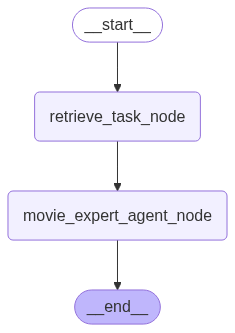

In [30]:
# visualização do workflow
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
# prompt e resposta
input_question = "Sugira filmes sobre a 2ª guerra mundial e faça uma breve análise sobre os mesmos."

result = graph.invoke({
    "question": input_question
})

print("Resposta:\n", result["answer"])


Resposta:
 Aqui estão algumas sugestões de filmes sobre a Segunda Guerra Mundial, com uma breve análise de cada um:

1. **Company of Heroes**
   - **Descrição**: Este filme de ação e aventura retrata a última grande ofensiva alemã durante a Segunda Guerra Mundial, onde um grupo de soldados aliados enfrenta desafios extremos para tentar mudar o rumo da guerra.
   - **Análise**: "Company of Heroes" é uma representação intensa da bravura e do sacrifício dos soldados aliados. O filme destaca a camaradagem entre os soldados e as dificuldades enfrentadas em um cenário de guerra caótico. A ação é central, mas também há um foco nas decisões morais e nas consequências da guerra.

2. **Final Account**
   - **Descrição**: Este documentário apresenta entrevistas inéditas com a última geração de pessoas que participaram do Terceiro Reich de Hitler.
   - **Análise**: "Final Account" oferece uma perspectiva única e pessoal sobre a Segunda Guerra Mundial, explorando as memórias e reflexões dos que viv

In [32]:
# checando contexto recuperado
print(result["context"])

Title: Company of Heroes (Movie)
Description: During the last major German offensive of World War II, a group of Allied soldiers sets out against all odds to turn the war around.
Categories: Action & Adventure, Dramas

Title: Final Account (Movie)
Description: This documentary stitches together never-before-seen interviews with the last living generation of people who participated in Hitler's Third Reich.
Categories: Documentaries

Title: Europe's Most Dangerous Man: Otto Skorzeny in Spain (Movie)
Description: Declassified documents reveal the post-WWII life of Otto Skorzeny, a close Hitler ally who escaped to Spain and became an adviser to world presidents.
Categories: Documentaries, International Movies


## Referências


Documentação do Chroma: https://docs.trychroma.com/docs/overview/getting-started

Documentação oficial da OpenAI sobre Embeddings: https://platform.openai.com/docs/api-reference/embeddings

Documentação oficial da OpenAI sobre RAG: https://help.openai.com/en/articles/8868588-retrieval-augmented-generation-rag-and-semantic-search-for-gpts

Documentação sobre banco de dados de vetores da Microsoft: https://learn.microsoft.com/en-us/data-engineering/playbook/solutions/vector-database/

Documentação sobre banco de dados de vetores da Pinecone: https://www.pinecone.io/learn/vector-database/

Livro sobre NLP: https://web.stanford.edu/~jurafsky/slp3/